In [11]:
import matplotlib.pyplot as plt
from itertools import combinations
from scripts import *
from plotter import *
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from dataloader import *
from tensorflow.keras import Model, layers
from dataloader import *
import numpy as np
parula_map = get_parula_map()

In [9]:
batch_size = 1000
learning_rate = 1e-3
display_step = 10

In [3]:
# load and center dataset
coordinates, potentials = load_dataset("../data/T028.txt", 13)
coordinates_, potentials_ = load_dataset("../data/T04.txt", 13)
coordinates = center_dataset(coordinates)
coordinates_ = center_dataset(coordinates_)

In [4]:
'''
 store two different adjacency matrices in two lists
 adj_R are pairwise distances
 adj_G are pairwise connections (0 or 1)
'''
adjacency_matrices = np.array([get_adjacent_matrices(coordinate, 1.3) for coordinate in coordinates])
adj_R = np.expand_dims(adjacency_matrices[:, 0], axis=3)
adj_G = np.expand_dims(adjacency_matrices[:, 1], axis=3)
adj_R = adj_R / np.max(adj_R.flatten())

adjacency_matrices_ = np.array([get_adjacent_matrices(coordinate, 1.3) for coordinate in coordinates_])
adj_R_ = np.expand_dims(adjacency_matrices_[:, 0], axis=3)
adj_G_ = np.expand_dims(adjacency_matrices_[:, 1], axis=3)
adj_R_ = adj_R_ / np.max(adj_R_.flatten())
inp = adj_R * adj_G

In [10]:
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((adj_R, potentials))
train_data = train_data.repeat().shuffle(len(adj_R)).batch(batch_size).prefetch(1)

In [7]:
class model(Model):
    def __init__(self):
        super(model, self).__init__()
        # define various layers
        self.conv1 = layers.Conv2D(32, [2, 2])
        self.pool1 = layers.MaxPool2D([2, 2])
        self.fc1 = layers.Dense(13)
        self.fc3 = layers.Dense(3)
        self.fc4 = layers.Dense(1)
        self.flatten = layers.Flatten()
        self.bnorm = layers.BatchNormalization()
    def call(self, x):
        #conv layers
        x = tf.nn.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.flatten(x)
        x = self.bnorm(x)
        #fully connected layers
        x = tf.nn.relu(self.fc1(x))
        x = tf.nn.relu(self.fc3(x))
        self.reduced_layer = x
        #output layer is linear
        x = self.fc4(x)
        return x 
energy_predictor = model()

In [43]:
@tf.function
def l2_loss(x, y):
    x = tf.cast(x, tf.float64)
    y = tf.cast(y, tf.float64)
    loss = (1./batch_size)*tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(y, x))))
    return loss

In [44]:
# Adam optimizer.
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(learning_rate,
                                                             decay_steps=1000,
                                                             decay_rate=0.96,
                                                             staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [45]:
@tf.function
def run_optimization(x, y):
    with tf.GradientTape() as g:
        pred = energy_predictor(x)
        loss = l2_loss(pred, y)
    gradients = g.gradient(loss, energy_predictor.trainable_variables)
    optimizer.apply_gradients(zip(gradients, energy_predictor.trainable_variables))

In [104]:

#Code for training loop 
'''
energy_predictor.load_weights("../models/13p_t4.ckpt")
for step, (batch_x, batch_y) in enumerate(train_data.take(1000), 1):
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)
    if step % 20 == 0:
        loss = l2_loss(energy_predictor(batch_x), batch_y)
        print("step: %i, loss: %f" % (step, loss))
energy_predictor.save_weights("../models/13p_t4_1.ckpt")
'''

step: 20, loss: 0.409932
step: 40, loss: 0.398876
step: 60, loss: 0.414858
step: 80, loss: 0.406208
step: 100, loss: 0.382319
step: 120, loss: 0.408479
step: 140, loss: 0.387332
step: 160, loss: 0.427780
step: 180, loss: 0.408885
step: 200, loss: 0.386788
step: 220, loss: 0.401081
step: 240, loss: 0.401228
step: 260, loss: 0.393940
step: 280, loss: 0.401300
step: 300, loss: 0.404587
step: 320, loss: 0.413227
step: 340, loss: 0.397374
step: 360, loss: 0.412579
step: 380, loss: 0.404693
step: 400, loss: 0.413225
step: 420, loss: 0.403739
step: 440, loss: 0.398481
step: 460, loss: 0.400708
step: 480, loss: 0.393993
step: 500, loss: 0.417152
step: 520, loss: 0.390248
step: 540, loss: 0.400244
step: 560, loss: 0.400985
step: 580, loss: 0.410132
step: 600, loss: 0.396910
step: 620, loss: 0.398547
step: 640, loss: 0.399989
step: 660, loss: 0.407529
step: 680, loss: 0.411637
step: 700, loss: 0.402291
step: 720, loss: 0.399276
step: 740, loss: 0.414620
step: 760, loss: 0.394799
step: 780, loss:

In [139]:
clusters = []
num_clusters = []
adjacency_matrices = []
spectral_radius = []
spectrum = []
vecs = []

#connectivity values
connectivity = []
connectivity_r = []
for i in range(len(adj_G)):
    connectivity.append(np.mean(np.sum(adj_G[i], axis=1)))
    connectivity_r.append(np.mean(np.sum(adj_R[i], axis=1)))

adj_R_ = np.squeeze(adj_R_)
#radius of gyration
rg_ = np.zeros(len(adj_G))
for i in range(len(adj_G)):
    rg_[i] = 0.5 * (1./len(adj_R[i])) * np.sum(np.sum(adj_R_[i], axis=1))/2.

#cluster weight distribution
cluster_weight_distribution = []
for i in range(len(clusters)):
    n_ = len(clusters[i])
    c_ = np.array([len(c) for c in clusters[i]])
    cluster_weight_distribution.append(np.sum(c_)/n_)

In [114]:
energy_predictor.load_weights("../models/13p_t4.ckpt")
y1 = energy_predictor(adj_R)
L_028=energy_predictor.reduced_layer
y2 = energy_predictor(adj_R_)
L_04=energy_predictor.reduced_layer

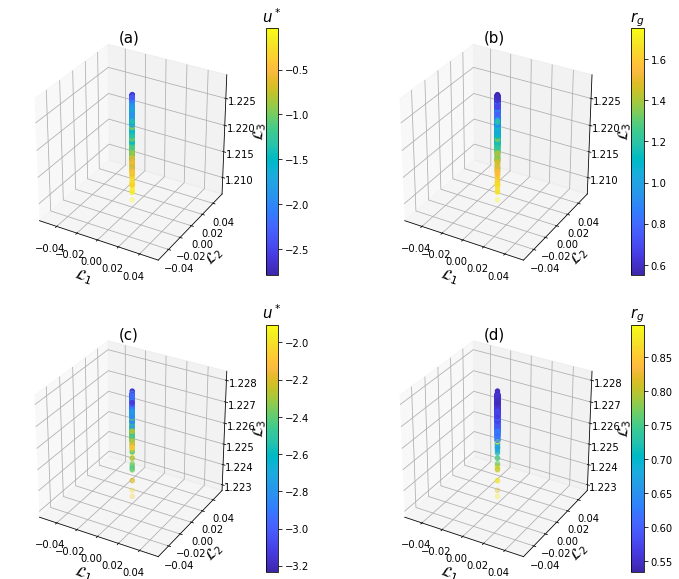

In [149]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10), subplot_kw=dict(projection='3d'))
x = np.arange(0, 10)
a1 = axs[0, 0].scatter(L_04[:, 0], L_04[:, 1],L_04[:, 2],c = potentials_, cmap=parula_map)
axs[0, 0].set_title('(a)', fontsize=15)
cl1= plt.colorbar(a1, ax=axs[0, 0])
cl1.ax.set_title('$u^*$', fontsize=15)
a2 = axs[0, 1].scatter(L_04[:, 0], L_04[:, 1],L_04[:, 2],c = rg_, cmap=parula_map)
axs[0, 1].set_title('(b)', fontsize=15)
cl2=plt.colorbar(a2, ax=axs[0, 1])
cl2.ax.set_title('$r_g$', fontsize=15)
a3 = axs[1, 0].scatter(L_028[:, 0], L_028[:, 1],L_028[:, 2],c = potentials, cmap=parula_map)
axs[1, 0].set_title('(c)', fontsize=15)
cl3=plt.colorbar(a3, ax=axs[1, 0])
cl3.ax.set_title('$u^*$', fontsize=15)
a4 = axs[1, 1].scatter(L_028[:, 0], L_028[:, 1],L_028[:, 2],c = rg, cmap=parula_map)
axs[1, 1].set_title('(d)', fontsize=15)
cl4=plt.colorbar(a4, ax=axs[1, 1])
cl4.ax.set_title('$r_g$', fontsize=15)
for ax in axs.flat:
    ax.set_xlabel('$\mathcal{L}_1$', fontname='sans serif', fontsize=15)
    ax.set_ylabel('$\mathcal{L}_2$', fontname='sans serif', fontsize=15)
    ax.set_zlabel('$\mathcal{L}_3$', fontname='sans serif', fontsize=15)

plt.savefig("cnn_results.png", dpi=1200)

In [124]:
clusters = []
num_clusters = []
adjacency_matrices = []
spectral_radius = []
spectrum = []
vecs = []

#connectivity values
connectivity = []
connectivity_r = []
for i in range(len(adj_G)):
    connectivity.append(np.mean(np.sum(adj_G[i], axis=1)))
    connectivity_r.append(np.mean(np.sum(adj_R[i], axis=1)))

#radius of gyration
rg = np.zeros(len(adj_G))
for i in range(len(adj_G)):
    rg[i] = 0.5 * (1./len(adj_R[i])) * np.trace(adj_R[i])

#cluster weight distribution
cluster_weight_distribution = []
for i in range(len(clusters)):
    n_ = len(clusters[i])
    c_ = np.array([len(c) for c in clusters[i]])
    cluster_weight_distribution.append(np.sum(c_)/n_)